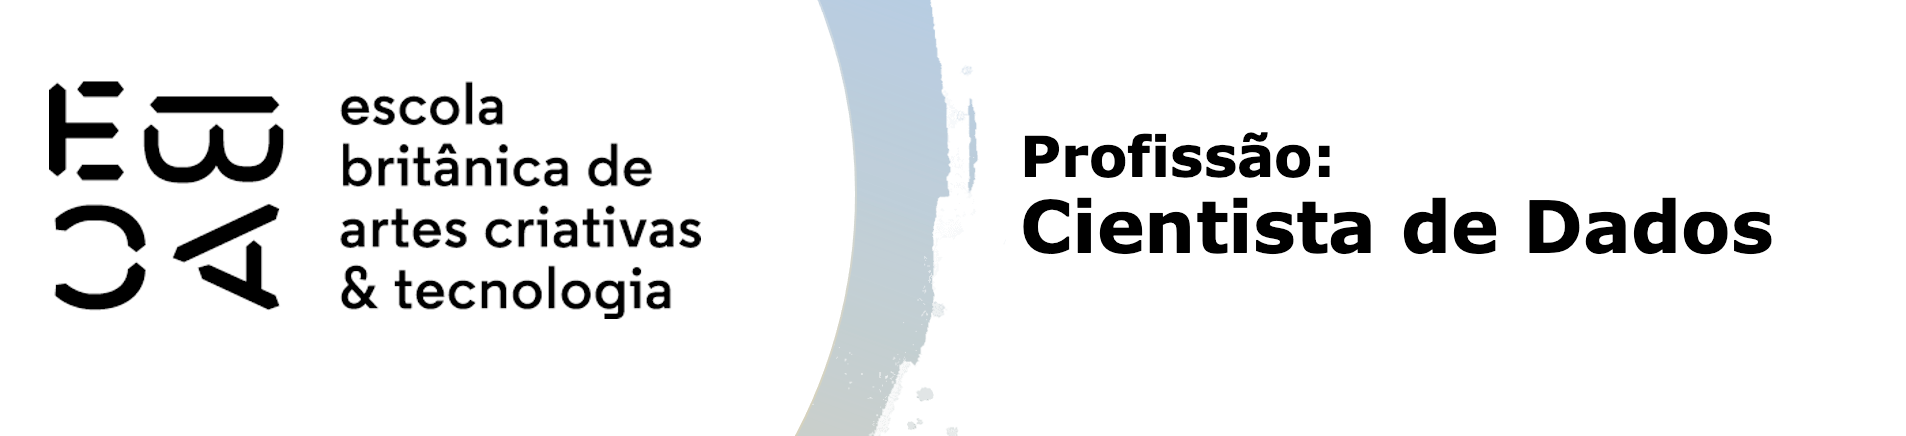

# Tarefa I

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
import pandas as pd
from pycaret.classification import *
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Dicionário dos Meses.

meses = {1:  'Jan',
         2:  'Fev',
         3:  'Mar',
         4:  'Abr',
         5:  'Mai',
         6:  'Jun',
         7:  'Jul',
         8:  'Ago',
         9:  'Set',
         10: 'Out',
         11: 'Nov',
         12: 'Dez'}

In [3]:
df = pd.read_feather('credit_scoring.ftr')
df.set_index(keys='data_ref', inplace=True)
df.index = df.index.month.map(meses) + '_' + df.index.year.astype(str)
df.drop(columns='index', inplace=True)
df.head()

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
data_ref,,,,,,,,,,,,,
Jan_2015,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
Jan_2015,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
Jan_2015,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
Jan_2015,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
Jan_2015,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [4]:
df_valid = df.loc[df.index.isin(['Jan_2016', 'Fev_2016', 'Mar_2016'])]
df = df.loc[~df.index.isin(['Jan_2016', 'Fev_2016', 'Mar_2016'])]

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [5]:
# Número de linhas para cada mês tanto do Treino quanto do Teste.

print(f'\033[1;92mDF:\033[0;1m\n{df.index.value_counts()}')
print('-'*25)
print(f'\033[1;94mDF_VALID:\033[0;1m{df_valid.index.value_counts()}')

DF:
data_ref
Jan_2015    50000
Fev_2015    50000
Mar_2015    50000
Abr_2015    50000
Mai_2015    50000
Jun_2015    50000
Jul_2015    50000
Ago_2015    50000
Set_2015    50000
Out_2015    50000
Nov_2015    50000
Dez_2015    50000
Name: count, dtype: int64
-------------------------
DF_VALID:data_ref
Jan_2016    50000
Fev_2016    50000
Mar_2016    50000
Name: count, dtype: int64


In [6]:
# Variáveis Quantitativas
df.describe().T

,count,mean,std,min,25%,50%,75%,max
qtd_filhos,600000.0,0.433210,0.739869,0.000000,0.000000,0.000000,1.000000,1.400000e+01
idade,600000.0,43.798530,11.230659,22.000000,34.000000,43.000000,53.000000,6.800000e+01
tempo_emprego,499125.0,7.747992,6.688576,0.117808,3.049315,6.046575,10.180822,4.290685e+01
qt_pessoas_residencia,600000.0,2.212122,0.903757,1.000000,2.000000,2.000000,3.000000,1.500000e+01
renda,600000.0,27222.844732,87377.875997,161.860000,4670.600000,9887.580000,21628.870000,4.083986e+06


In [7]:
# Variáveis Qualitativas
df.describe(include=['object']).T

,count,unique,top,freq
sexo,600000,2,F,403805
posse_de_veiculo,600000,2,N,366293
posse_de_imovel,600000,2,S,403054
tipo_renda,600000,5,Assalariado,308460
educacao,600000,5,Médio,405449
estado_civil,600000,5,Casado,421149
tipo_residencia,600000,6,Casa,539336


In [8]:
df.select_dtypes(include='number').columns

Index(['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia',
       'renda'],
      dtype='object')

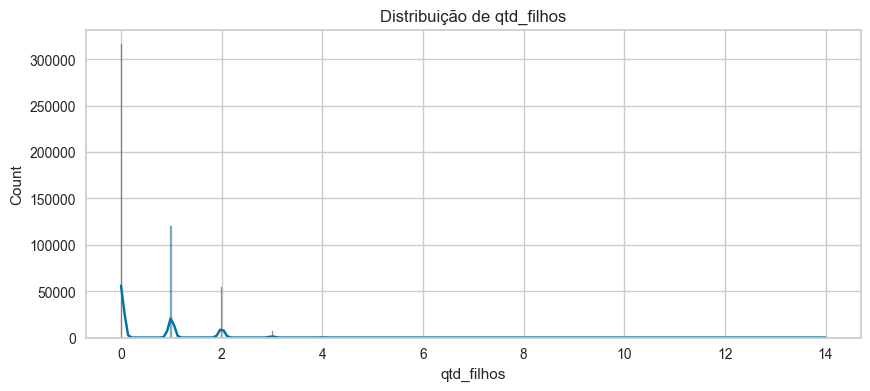

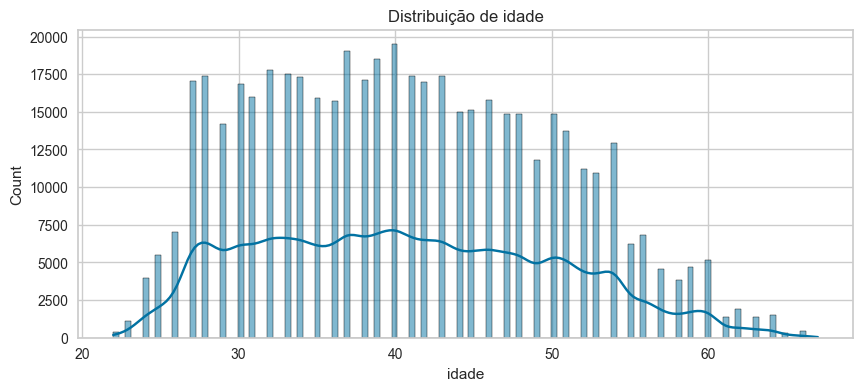

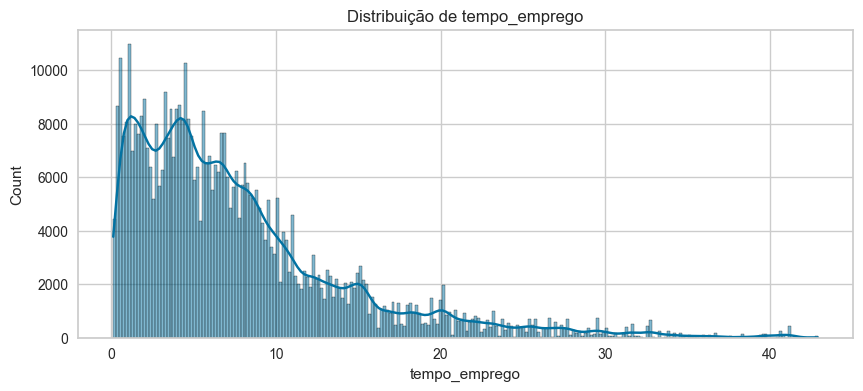

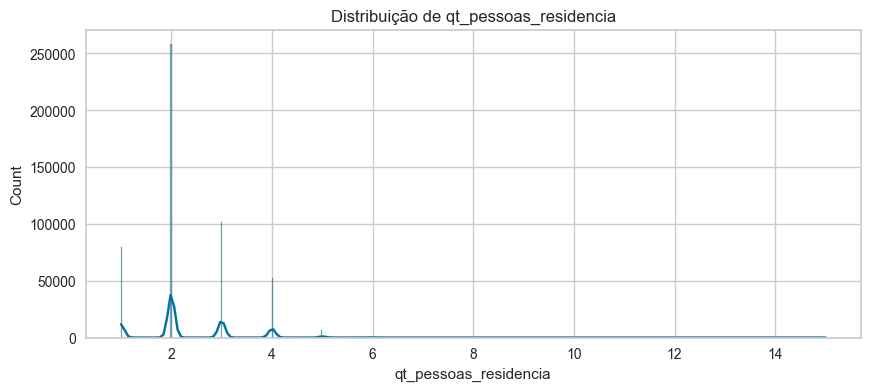

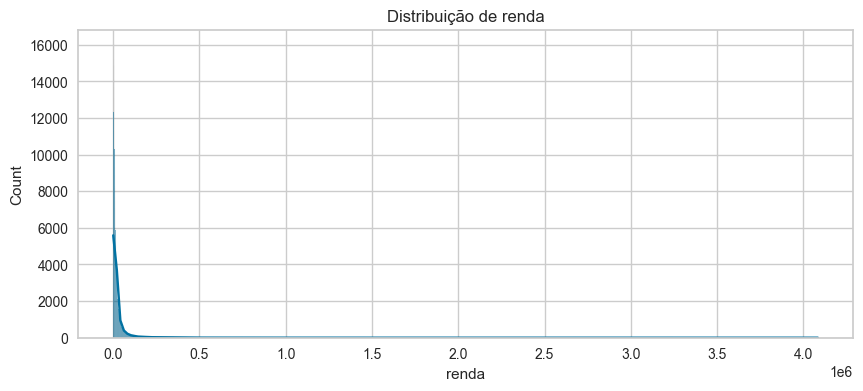

In [12]:
for col in df.select_dtypes(include='number').columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(data=df.fillna({'tempo_emprego': -1}), x=col, kde=True)
    plt.title('Distribuição de ' + col)
    plt.show()

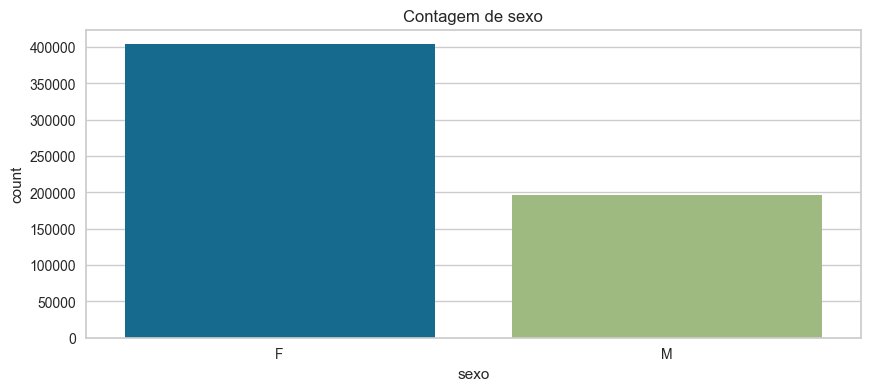

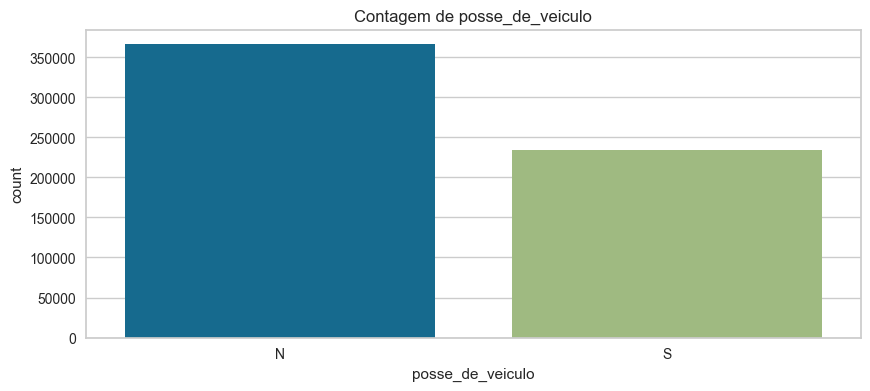

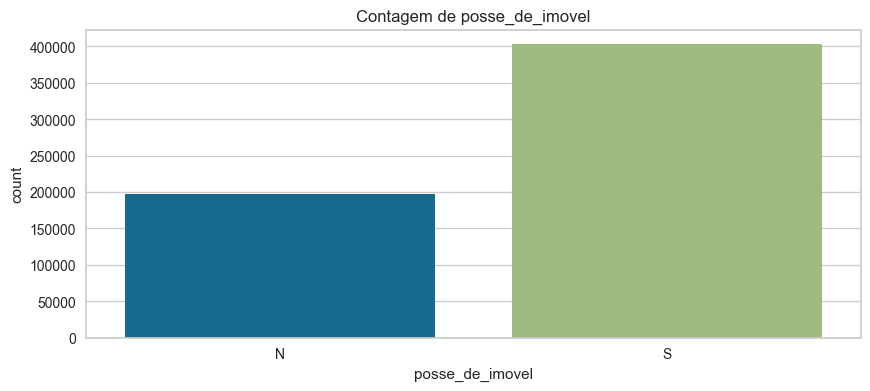

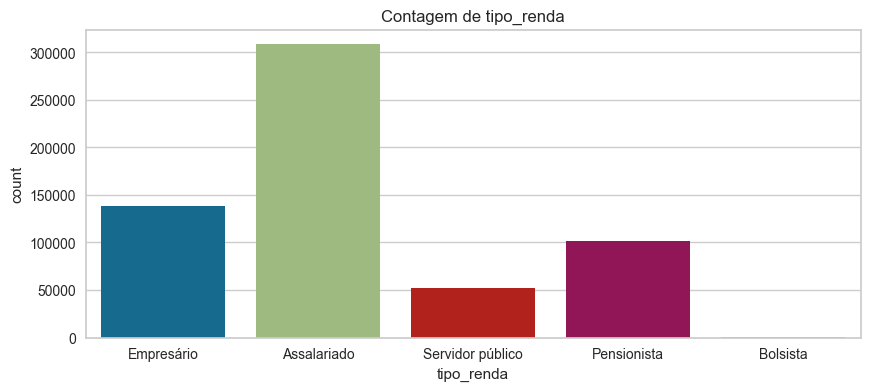

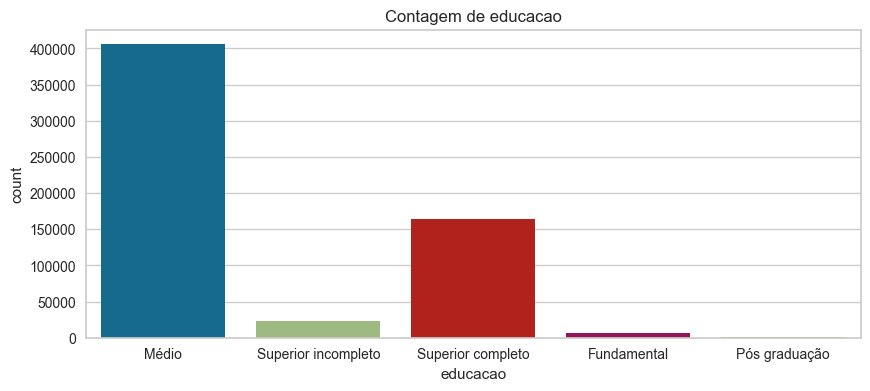

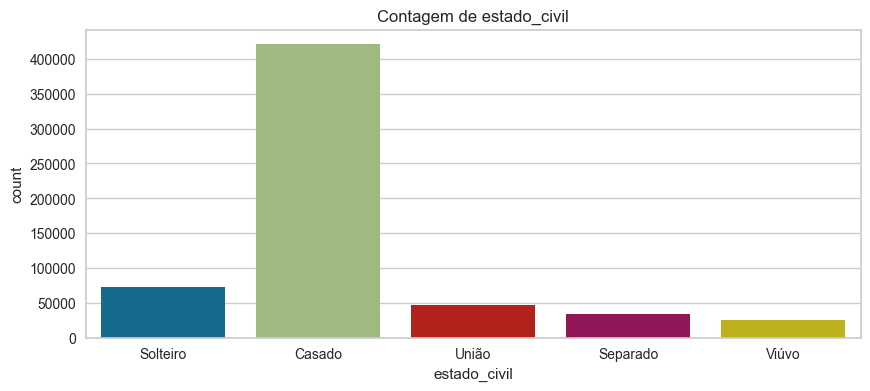

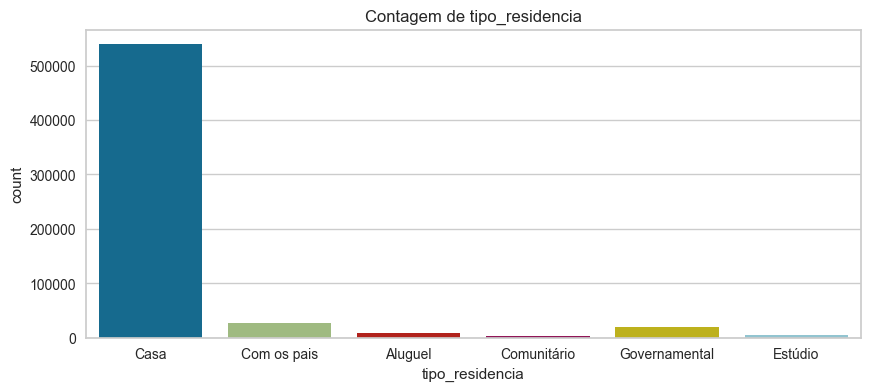

In [13]:
for col in df.select_dtypes(include=['object']).columns:
    plt.figure(figsize=(10, 4))
    sns.countplot(data=df, x=col)
    plt.title('Contagem de ' + col)
    plt.show()

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento 

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

# b - Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [ ]:
import pandas as pd

df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [ ]:
from pycaret.classification import *
models()

ValueError: _CURRENT_EXPERIMENT global variable is not set. Please run setup() first.

In [ ]:
xxx = create_model('xxx')